Read and Visualise Geophysical Potential-Fields
==========

Geophysical potential fields (gravity and magnetics) can be calculated directly from the generated kinematic model. A wide range of options also exists to consider effects of geological events on the relevant rock properties. We will here use pynoddy to simply and quickly test the effect of changing geological structures on the calculated geophysical response.

In [1]:
%matplotlib inline

In [6]:
import sys, os
import matplotlib.pyplot as plt
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
repo_path = os.path.realpath('../..')
import pynoddy

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
from IPython.core.display import HTML
css_file = 'pynoddy.css'
HTML(open(css_file, "r").read())

Read history file from Virtual Explorer
---------------------------------------

Many Noddy models are available on the site of the Virtual Explorer in the Structural Geophysics Atlas. We will download and use one of these models here as the base model.

We start with the history file of a "Fold and Thrust Belt" setting stored on:

`http://tectonique.net/asg/ch3/ch3_5/his/fold_thrust.his`

The file can directly be downloaded and opened with pynoddy:

In [9]:
import pynoddy.history
reload(pynoddy.history)

his = pynoddy.history.NoddyHistory(url = \
            "http://tectonique.net/asg/ch3/ch3_5/his/fold_thrust.his")

his.determine_model_stratigraphy()

In [10]:
his.change_cube_size(50)

In [11]:
# Save to (local) file to compute and visualise model
history_name = "fold_thrust.his"
his.write_history(history_name)
# his = pynoddy.history.NoddyHistory(history_name)

In [12]:
output = "fold_thrust_out"
pynoddy.compute_model(history_name, output)

''

In [13]:
import pynoddy.output
# load and visualise model
h_out = pynoddy.output.NoddyOutput(output)

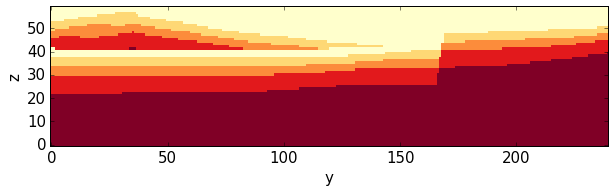

In [14]:
# his.determine_model_stratigraphy()
h_out.plot_section('x', 
                   layer_labels = his.model_stratigraphy, 
                   colorbar_orientation = 'horizontal', 
                   colorbar=False,
                   title = '',
#                   savefig=True, fig_filename = 'fold_thrust_NS_section.eps',
                   cmap = 'YlOrRd')


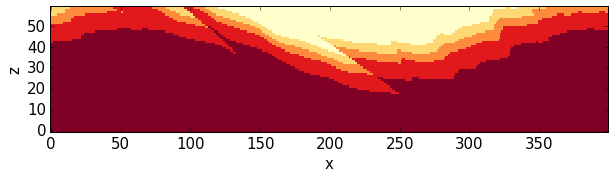

In [15]:
h_out.plot_section('y', layer_labels = his.model_stratigraphy, 
                   colorbar_orientation = 'horizontal', title = '', cmap = 'YlOrRd', 
#                   savefig=True, fig_filename = 'fold_thrust_EW_section.eps',
                   ve=1.5)
                   

In [16]:
h_out.export_to_vtk(vtk_filename = "fold_thrust")

Visualise calculated geophysical fields
---------------------

The first step is to recompute the model with the generation of the geophysical responses

In [17]:
pynoddy.compute_model(history_name, output, sim_type = 'BLOCK')

''

We now get two files for the caluclated fields: '.grv' for gravity, and '.mag' for the magnetic field. We can extract the information of these files for visualisation and further processing in python:

In [18]:
reload(pynoddy.output)
geophys = pynoddy.output.NoddyGeophysics(output)

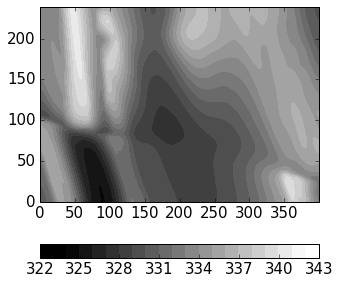

In [19]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
# imshow(geophys.grv_data, cmap = 'jet')
# define contour levels
levels = np.arange(322,344,1)
cf = ax.contourf(geophys.grv_data, levels, cmap = 'gray', vmin = 324, vmax = 342)
cbar = plt.colorbar(cf, orientation = 'horizontal')
# print levels

Change history and compare gravity
-------------

As a next step, we will now change aspects of the geological history (paramtereised in as parameters of the kinematic events) and calculate the effect on the gravity. Then, we will compare the changed gravity field to the original field.

Let's have a look at the properties of the defined faults in the original model:

In [20]:
for i in range(4):
    print("\nEvent %d" % (i+2))
    print "Event type:\t" + his.events[i+2].event_type
    print "Fault slip:\t%.1f" % his.events[i+2].properties['Slip']
    print "Fault dip:\t%.1f" % his.events[i+2].properties['Dip']
    print "Dip direction:\t%.1f" % his.events[i+2].properties['Dip Direction']


Event 2
Event type:	FAULT
Fault slip:	-5000.0
Fault dip:	0.0
Dip direction:	90.0

Event 3
Event type:	FAULT
Fault slip:	-3000.0
Fault dip:	0.0
Dip direction:	90.0

Event 4
Event type:	FAULT
Fault slip:	-3000.0
Fault dip:	0.0
Dip direction:	90.0

Event 5
Event type:	FAULT
Fault slip:	12000.0
Fault dip:	80.0
Dip direction:	170.0


In [21]:
reload(pynoddy.history)
reload(pynoddy.events)
his2 = pynoddy.history.NoddyHistory("fold_thrust.his")

print his2.events[6].properties

{'Dip': 130.0, 'Cylindricity': 0.0, 'Wavelength': 12000.0, 'Amplitude': 1000.0, 'Pitch': 0.0, 'Y': 0.0, 'X': 0.0, 'Single Fold': 'FALSE', 'Z': 0.0, 'Type': 'Fourier', 'Dip Direction': 110.0}


As a simple test, we are changing the fault slip for all the faults and simply add 1000 m to all defined slips. In order to not mess up the original model, we are creating a copy of the history object first:

In [22]:
import copy
his = pynoddy.history.NoddyHistory(history_name)
his.all_events_end += 1
his_changed = copy.deepcopy(his)

# change parameters of kinematic events
slip_change = 2000.
wavelength_change = 2000.
# his_changed.events[3].properties['Slip'] += slip_change
# his_changed.events[5].properties['Slip'] += slip_change
# change fold wavelength
his_changed.events[6].properties['Wavelength'] += wavelength_change
his_changed.events[6].properties['X'] += wavelength_change/2.

We now write the adjusted history back to a new history file and then calculate the updated gravity field:

In [23]:
his_changed.write_history('fold_thrust_changed.his')

In [24]:
# %%timeit
# recompute block model
pynoddy.compute_model('fold_thrust_changed.his', 'fold_thrust_changed_out')

''

In [26]:
# pynoddy.compute_model??

In [27]:
# %%timeit
# recompute geophysical response
pynoddy.compute_model('fold_thrust_changed.his', 'fold_thrust_changed_out', 
                      sim_type = 'GEOPHYSICS')

''

In [28]:
# load changed block model
geo_changed = pynoddy.output.NoddyOutput('fold_thrust_changed_out')
# load output and visualise geophysical field
geophys_changed = pynoddy.output.NoddyGeophysics('fold_thrust_changed_out')

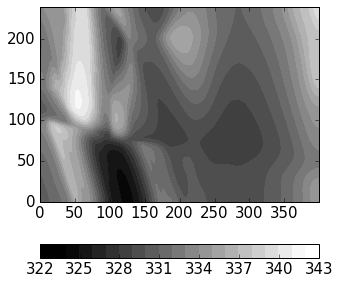

In [29]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
# imshow(geophys_changed.grv_data, cmap = 'jet')
cf = ax.contourf(geophys_changed.grv_data, levels, cmap = 'gray', vmin = 324, vmax = 342)
cbar = plt.colorbar(cf, orientation = 'horizontal')

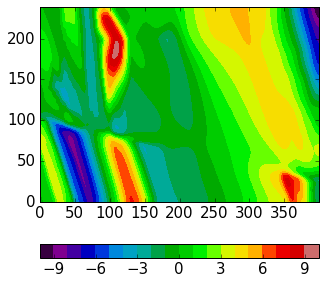

In [30]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
# imshow(geophys.grv_data - geophys_changed.grv_data, cmap = 'jet')
maxval = np.ceil(np.max(np.abs(geophys.grv_data - geophys_changed.grv_data)))
# comp_levels = np.arange(-maxval,1.01 * maxval, 0.05 * maxval)
cf = ax.contourf(geophys.grv_data - geophys_changed.grv_data, 20, 
                 cmap = 'spectral')
cbar = plt.colorbar(cf, orientation = 'horizontal')

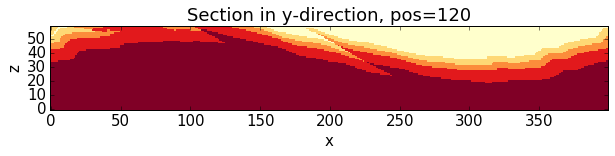

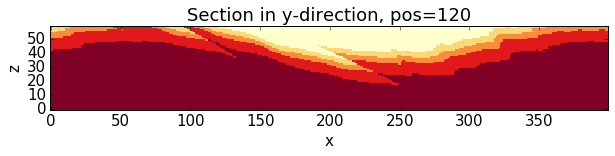

In [31]:
# compare sections through model
geo_changed.plot_section('y', colorbar = False)
h_out.plot_section('y', colorbar = False)

In [32]:
for i in range(4):
    print("Event %d" % (i+2))
    print his.events[i+2].properties['Slip']
    print his.events[i+2].properties['Dip']
    print his.events[i+2].properties['Dip Direction']

    

Event 2
-5000.0
0.0
90.0
Event 3
-3000.0
0.0
90.0
Event 4
-3000.0
0.0
90.0
Event 5
12000.0
80.0
170.0


In [33]:
# recompute the geology blocks for comparison:
pynoddy.compute_model('fold_thrust_changed.his', 'fold_thrust_changed_out')

''

In [34]:
geology_changed = pynoddy.output.NoddyOutput('fold_thrust_changed_out')

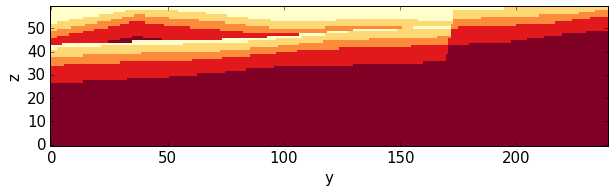

In [35]:
geology_changed.plot_section('x', 
#                    layer_labels = his.model_stratigraphy, 
                   colorbar_orientation = 'horizontal', 
                   colorbar=False,
                   title = '',
#                   savefig=True, fig_filename = 'fold_thrust_NS_section.eps',
                   cmap = 'YlOrRd')



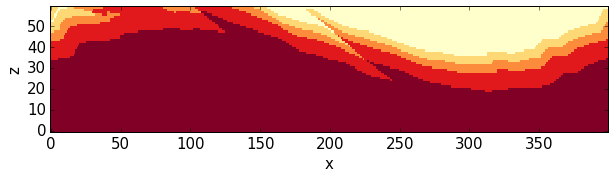

In [36]:
geology_changed.plot_section('y', 
                             # layer_labels = his.model_stratigraphy, 
                   colorbar_orientation = 'horizontal', title = '', cmap = 'YlOrRd', 
#                   savefig=True, fig_filename = 'fold_thrust_EW_section.eps',
                   ve=1.5)
                   

In [37]:
# Calculate block difference and export as VTK for 3-D visualisation:
import copy
diff_model = copy.deepcopy(geology_changed)
diff_model.block -= h_out.block

In [38]:
diff_model.export_to_vtk(vtk_filename = "diff_model_fold_thrust_belt")

Figure with all results
--------

We now create a figure with the gravity field of the original and the changed model, as well as a difference plot to highlight areas with significant changes. This example also shows how additional equations can easily be combined with pynoddy classes.

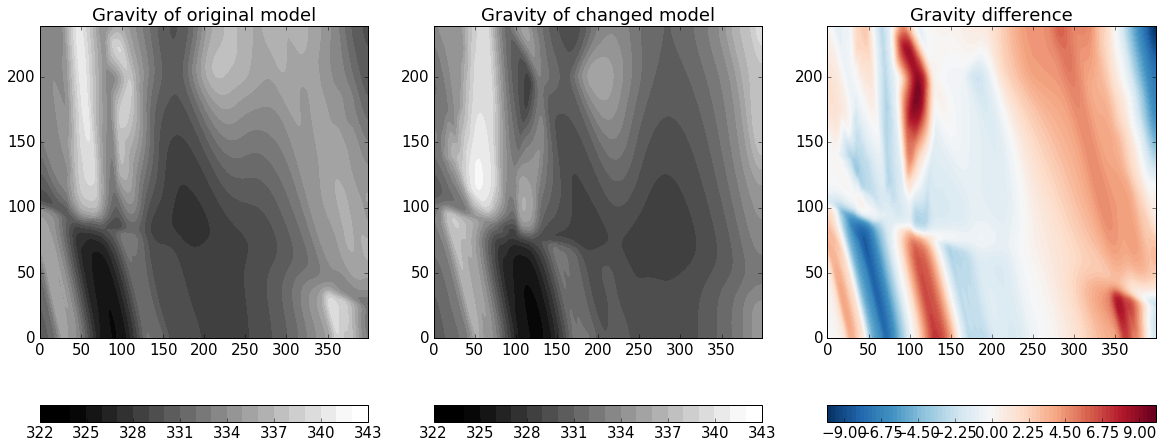

In [39]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(131)
# original plot
levels = np.arange(322,344,1)
cf1 = ax1.contourf(geophys.grv_data, levels, cmap = 'gray', vmin = 324, vmax = 342)
# cbar1 = ax1.colorbar(cf1, orientation = 'horizontal')
fig.colorbar(cf1, orientation='horizontal')
ax1.set_title('Gravity of original model')

ax2 = fig.add_subplot(132)




cf2 = ax2.contourf(geophys_changed.grv_data, levels, cmap = 'gray', vmin = 324, vmax = 342)
ax2.set_title('Gravity of changed model')
fig.colorbar(cf2, orientation='horizontal')

ax3 = fig.add_subplot(133)


comp_levels = np.arange(-10.,10.1,0.25)
cf3 = ax3.contourf(geophys.grv_data - geophys_changed.grv_data, comp_levels, cmap = 'RdBu_r')
ax3.set_title('Gravity difference')

fig.colorbar(cf3, orientation='horizontal')

plt.savefig("grav_ori_changed_compared.eps")

